## Run me first

First of all, run the following cell to initialize the API. The output will contain instructions on how to grant this notebook access to Earth Engine using your account.

In [5]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()


Successfully saved authorization token.


## Getting started with Collections

In the Earth Engine Data Catalog, datasets can be of different types:

- *Features* which are geometric objects with a list of properties. For example, a watershed with some properties such as *name* and *area*, is an `ee.Feature`.
- *Images* which are like features, but may include several bands. For example, the ground elevation given by the USGS [here](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003) is an `ee.Image`.
- *Collections* which are groups of features or images. For example, the [Global Administrative Unit Layers](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_2015_level0) giving administrative boundaries is a `ee.FeatureCollection` and the [MODIS Land Surface Temperature](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) dataset is an `ee.ImageCollection`.

If you want to know more about different data models, you may want to visit the [Earth Engine User Guide](https://developers.google.com/earth-engine).

In the following sections, we work with the MODIS [land cover (LC)](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MCD12Q1), the MODIS [land surface temperature (LST)](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1) and with the USGS [ground elevation (ELV)](https://developers.google.com/earth-engine/datasets/catalog/USGS_SRTMGL1_003), which are `ee.ImageCollections`. The dataset descriptions provide us with all the information we need to import and manipulate these datasets: the availability, the provider, the Earth Engine Snippet, and the available bands associated with images in the collection.

Now, to import the LC, LST and ELV collections, we can copy and paste the Earth Engine Snippets:

In [6]:
# Import the MODIS land cover collection.
lc = ee.ImageCollection('MODIS/006/MCD12Q1')

# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection('MODIS/006/MOD11A1')

new_ds = ee.ImageCollection('MODIS/061/MOD13Q1')

# Import the USGS ground elevation image.
elv = ee.Image('USGS/SRTMGL1_003')

All of these images come in a different resolution, frequency, and possibly projection, ranging from daily images in a 1 km resolution for LST (hence an `ee.ImageCollection` — a collection of several `ee.Images`) to a single image representing data for the year 2000 in a 30 m resolution for the ELV. While we need to have an eye on the frequency, GEE takes care of resolution and projection by resampling and reprojecting all data we are going to work with to a common projection (learn more about [projections in Earth Engine](https://developers.google.com/earth-engine/guides/projections)). We can define the resolution (called scale in GEE) whenever necessary and of course have the option to force no reprojection.

As you can see in the description of the datasets, they include several sets of information stored in several bands. For example, these bands are associated with the LST collection:

- _LST\_Day\_1km_: Daytime Land Surface Temperature
- _Day\_view\_time_: Local time of day observation
- _LST\_Night\_1km_: Nighttime Land Surface Temperature
- etc.

The description page of the collection tells us that the name of the band associated with the daytime LST is _LST\_Day\_1km_ which is in units of Kelvin. In addition, values are ranging from 7,500 to 65,535 with a corrective scale of 0.02.

Then, we have to filter the collection on the period of time we want. We can do that using the `filterDate()` method. We also need to select the bands we want to work with. Therefore, we decide to focus on daytime LST so we select the daytime band _LST\_Day\_1km_ and its associated quality indicator _QC\_Day_ with the `select()` method.

In [7]:
# Initial date of interest (inclusive).
i_date = '2017-01-01'

# Final date of interest (exclusive).
f_date = '2020-01-01'

# Selection of appropriate bands and dates for LST.
lst = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

# Initial date of interest (inclusive).
new_i_date = '2017-01-01'

# Final date of interest (exclusive).
new_f_date = '2020-01-01'

new_ds = new_ds.select('NDVI', 'EVI').filterDate(new_i_date, new_f_date)

Now, we can either upload existing shape files or define some points with longitude and latitude coordinates where we want to know more about LC, LST and ELV. For this example, let's use two point locations:

- The first one in the urban area of Lyon, France
- The second one, 30 kilometers away from the city center, in a rural area

In [8]:
# Define the urban location of interest as a point near Lyon, France.
u_lon = 4.8148
u_lat = 45.7758
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the rural location of interest as a point away from the city.
r_lon = 5.175964
r_lat = 45.574064
r_poi = ee.Geometry.Point(r_lon, r_lat)

We can easily get information about our region/point of interest using the following methods (to get more information about available methods and required arguments, please visit the API documentation [here](https://developers.google.com/earth-engine/api_docs)):

- `sample()`: samples the image (does NOT work for an `ee.ImageCollection` — we'll talk about sampling an `ee.ImageCollection` later) according to a given geometry and a scale (in meters) of the projection to sample in. It returns an `ee.FeatureCollection`.
- `first()`: returns the first entry of the collection,
- `get()`: to select the appropriate band of your Image/Collection,
- `getInfo()`: evaluates server-side expression graph and transfers result to client.

Then we can query the ground elevation and LST around our point of interest using the following commands. Please be careful when evaluating LST. According to the [dataset description](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1), the value should be corrected by a factor of 0.02 to get units of Kelvin (do not forget the conversion). To get the mean multi-annual daytime LST, we use the `mean()` collection reduction method on the LST `ee.ImageCollection`. (The following run might take about 15-20 seconds)

In [9]:
scale = 1000  # scale in meters

# Print the elevation near Lyon, France.
elv_urban_point = elv.sample(u_poi, scale).first().get('elevation').getInfo()
print('Ground elevation at urban point:', elv_urban_point, 'm')

# Calculate and print the mean value of the LST collection at the point.
lst_urban_point = lst.mean().sample(u_poi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_urban_point*0.02 -273.15, 2), '°C')

# Print the land cover type at the point.
lc_urban_point = lc.first().sample(u_poi, scale).first().get('LC_Type1').getInfo()
print('Land cover value at urban point is:', lc_urban_point)

# print(lc)
# print(lc.first().sample(u_poi, scale))

Ground elevation at urban point: 196 m
Average daytime LST at urban point: 23.12 °C
Land cover value at urban point is: 13


In [10]:
scale = 1000  # scale in meters

# Calculate and print the mean value of the LST collection at the point.
new_urban_point = new_ds.first().sample(u_poi, scale).first().get('NDVI').getInfo()
print('Average NDVI at urban point:', new_urban_point)


Average NDVI at urban point: 3067


In [11]:
from IPython.display import Image

new_img = new_ds.mean()

new_img = new_img.select('NDVI')

roi = u_poi.buffer(1e6)

# Create a URL to the styled image for a region around France.
url = new_img.getThumbUrl({
    'min': 0.0,
    'max': 9000.0,
    'dimensions': 512,
    'region': roi,
    'palette': [
      'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
      '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
      '012E01', '011D01', '011301'
    ]})
print(url)

# Display the thumbnail land surface temperature in France.
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1alpha/projects/earthengine-legacy/thumbnails/93d9d2abe0f3d3fb99145229e0698f93-0914386be1ae03a3d315c314110b064f:getPixels

Please wait while the thumbnail loads, it may take a moment...


In [12]:
import folium
import numpy as np

# Define the center of our map.
lat, lon = 45.77, 4.855
center_point = np.array([[lat, lon]])

my_map = folium.Map(location=[lat, lon], zoom_start=10)
my_map



In [13]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [14]:

new_img = new_ds.mean()

new_img = new_img.select('NDVI')

roi = u_poi.buffer(1e6)

# Create a URL to the styled image for a region around France.
url = new_img.getThumbUrl({
    'min': 0.0,
    'max': 9000.0,
    'dimensions': 512,
    'region': roi,
    'palette': [
      'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
      '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
      '012E01', '011D01', '011301'
    ]})

# Set visualization parameters for land cover.
new_vis_params = {
'min': 0.0,
    'max': 9000.0,
    # 'dimensions': 512,
    # 'region': roi,
    'palette': [
      'FFFFFF', 'CE7E45', 'DF923D', 'F1B555', 'FCD163', '99B718', '74A901',
      '66A000', '529400', '3E8601', '207401', '056201', '004C00', '023B01',
      '012E01', '011D01', '011301']
}

# Create a map.
lat, lon = 45.77, 4.855
my_map = folium.Map(location=[lat, lon], zoom_start=7)

# Add the land cover to the map object.
my_map.add_ee_layer(new_img, new_vis_params, 'Land Cover')

# Add a layer control panel to the map.
my_map.add_child(folium.LayerControl())

# Display the map.
display(my_map)

In [15]:
# locationlist = [["45.77", "4.855"], ["45.77", "5.855"], ["45.77", "6.855"]]
import numpy as np
N = 10

# 111km = 1deg
def km_to_deg(km):
  return km/111

def m_to_deg(m):
  return (m/1.11)*0.00001

step_250 = m_to_deg(250)

radius = km_to_deg(1000)

lan, lon = 45.77, 4.855
points = [lan, lon] + (np.random.random((N,2))*2-1.0)*radius

str_points = [[str(point[0]),str(point[1])] for point in points]

print(str_points)


for point in range(0, len(str_points)):
    folium.Marker(str_points[point]).add_to(my_map)

display(my_map)

[['40.133221177207226', '-4.033300288548798'], ['52.89874719449709', '0.5927955626628734'], ['50.916839009707935', '8.098939939174757'], ['51.39516550167946', '-2.132272438281034'], ['38.43705165084633', '-3.1301944804066064'], ['42.519734487611416', '2.39905870760529'], ['51.45962681208976', '12.909767013562382'], ['49.07296331438405', '5.665262980514982'], ['48.06938930197121', '-1.6572192685176406'], ['52.66338669925897', '-1.403227351239975']]


In [16]:
from emukit.core import ParameterSpace, ContinuousParameter
from emukit.test_functions.forrester import forrester
from emukit.experimental_design import ExperimentalDesignLoop
import numpy as np
import GPy
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
from emukit.core.optimization import GradientAcquisitionOptimizer

def forrester_fcn(x):
    return forrester(x, sd=0)
target_function = np.sin
space = ParameterSpace([ContinuousParameter('x', 0, 1)])

X_init = np.array([[0.2],[0.6], [0.9]])
Y_init = target_function(X_init)

kern = GPy.kern.RBF(1, lengthscale=0.08, variance=20)
gpy_model = GPy.models.GPRegression(X_init, Y_init, kern, noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)

# mu_plot, var_plot = emukit_model.predict(x_plot)

us_acquisition = ModelVariance(emukit_model)
ivr_acquisition = IntegratedVarianceReduction(emukit_model, space)

#us_plot = us_acquisition.evaluate(x_plot)
#ivr_plot = ivr_acquisition.evaluate(x_plot)

optimizer = GradientAcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(us_acquisition)
y_new = target_function(x_new)
X = np.append(X_init, x_new, axis=0)
Y = np.append(Y_init, y_new, axis=0)

emukit_model.set_data(X, Y)
x_plot = np.linspace(space.parameters[0].min, space.parameters[0].max, 301)[:, None]
y_plot = target_function(x_plot)

ed = ExperimentalDesignLoop(space=space, model=emukit_model)

ed.run_loop(target_function, 10)

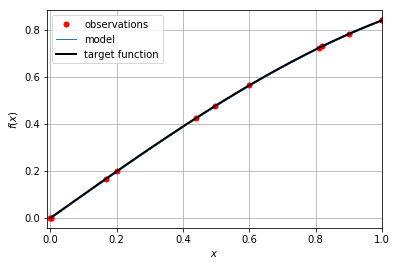

In [17]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
def helper_plot_emulator_errorbars():
    """Helper function for plotting the emulator fit."""
    mu_plot, var_plot = emukit_model.predict(x_plot)
    ax.plot(emukit_model.X, emukit_model.Y, 'ro', markersize=5, label='observations')
    ax.plot(x_plot, mu_plot, 'C0', label='model', linewidth=1)
    ax.plot(x_plot, y_plot, 'k', label='target function', linewidth=2)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
    ax.fill_between(x_plot[:, 0],
                 mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
                 mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    ax.legend(loc=2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$f(x)$')
    ax.grid(True)
    ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
helper_plot_emulator_errorbars()

In [58]:
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.test_functions.forrester import forrester
from emukit.experimental_design import ExperimentalDesignLoop
import numpy as np
import GPy
from emukit.experimental_design.acquisitions import IntegratedVarianceReduction, ModelVariance
from emukit.model_wrappers.gpy_model_wrappers import GPyModelWrapper
from emukit.core.optimization import GradientAcquisitionOptimizer

num_points = 41 # per direction
num_points_plot = num_points

def NDVI_at(coords):
    coords = center_point + m_to_deg(coords * (250 * num_points) / 2)
    # print(coords.shape)
    # print(coords[0])
    geom_coords = ee.FeatureCollection([ee.Geometry.Point(c[0], c[1]) for c in coords])
    samples = new_ds.mean().reduceRegions(**{
        'collection': geom_coords,
        'scale': scale,
        'reducer': 'mean'}).getInfo()
    sample_results = []
    for sample in samples['features']:
        # print(sample)
        sample_results = sample_results + [sample['properties']['NDVI']]
    # print('Samples: ', sample_results)
    # values = np.array([new_ds.mean().sample(ee.Geometry.Point(c[0], c[1]), scale).first().get('NDVI').getInfo() for c in coords])[:, None]
    values = np.array(sample_results)[:,None]
        # print(values)
    return values
target_function = NDVI_at
space = ParameterSpace([DiscreteParameter('x', np.linspace(-1, 1, num_points)), DiscreteParameter('y', np.linspace(-1, 1, num_points))])

X_init = np.array([[0.2, 0.4],[0.6, -0.4], [0.9, 0.0]])
Y_init = target_function(X_init)

k1 = GPy.kern.RBF(input_dim=2, lengthscale=0.08, variance=20)
k2 = GPy.kern.White(input_dim=2, variance=0.2)# 0.5, 0.2)
kern = GPy.kern.Kern.add(k1, k2) # k1 + k2 


gpy_model = GPy.models.GPRegression(X_init, Y_init, kern, noise_var=1e-10)
emukit_model = GPyModelWrapper(gpy_model)


us_acquisition = ModelVariance(emukit_model)
ivr_acquisition = IntegratedVarianceReduction(emukit_model, space)

optimizer = GradientAcquisitionOptimizer(space)
x_new, _ = optimizer.optimize(us_acquisition)
y_new = target_function(x_new)
X = np.append(X_init, x_new, axis=0)
Y = np.append(Y_init, y_new, axis=0)

emukit_model.set_data(X, Y)
# print(space.parameters)
x_plot = np.meshgrid(np.linspace(-1, 1, num_points_plot),
                     np.linspace(-1, 1, num_points_plot))

x_plot = np.stack((x_plot[1], x_plot[0]), axis=-1).reshape(-1,2)
# print(x_plot)

ed = ExperimentalDesignLoop(space=space, model=emukit_model)

ed.run_loop(target_function, 30)

mu_plot information: (1681, 1) 2393.791170271201 2393.791172944999
x_plot information: (1681, 2) -1.0 1.0
y_plot information: (1681, 1) 2234.0289855072465 2720.6376811594205


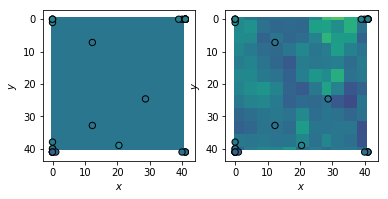

In [59]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2)
def plot_2D():
    mu_plot, var_plot = emukit_model.predict(x_plot)
    y_plot = target_function(x_plot)
    #print(x_plot.shape, mu_plot.shape, var_plot.shape)
    # ax.plot(emukit_model.X, emukit_model.Y, 'ro', markersize=5, label='observations')
    # ax.plot(x_plot, mu_plot, 'C0', label='model', linewidth=1)
    # ax.plot(x_plot, y_plot, 'k', label='target function', linewidth=2)
    # ax.fill_between(x_plot[:, 0],
    #              mu_plot[:, 0] + np.sqrt(var_plot)[:, 0],
    #              mu_plot[:, 0] - np.sqrt(var_plot)[:, 0], color='C0', alpha=0.6)
    # ax.fill_between(x_plot[:, 0],
    #              mu_plot[:, 0] + 2 * np.sqrt(var_plot)[:, 0],
    #              mu_plot[:, 0] - 2 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.4)
    # ax.fill_between(x_plot[:, 0],
    #              mu_plot[:, 0] + 3 * np.sqrt(var_plot)[:, 0],
    #              mu_plot[:, 0] - 3 * np.sqrt(var_plot)[:, 0], color='C0', alpha=0.2)
    # ax.legend(loc=2)
    #print(mu_plot.reshape(num_points, num_points).shape)
    # ax.imshow(mu_plot.reshape(num_points, num_points))
    
    print("mu_plot information:", mu_plot.shape, np.min(mu_plot), np.max(mu_plot))
    print("x_plot information:", x_plot.shape, np.min(x_plot), np.max(x_plot))
    print("y_plot information:", y_plot.shape, np.min(y_plot), np.max(y_plot))
    min_NDVI = 2000
    max_NDVI = 3000

    axes[0].imshow(mu_plot.reshape(num_points, num_points), vmin=min_NDVI, vmax=max_NDVI)
    axes[0].scatter((emukit_model.X[:, 1] + 1) * num_points / 2, (emukit_model.X[:, 0] + 1) * num_points / 2, c=emukit_model.Y[:, 0], label='observations', vmin=min_NDVI, vmax=max_NDVI, s=40, edgecolor='black')
    axes[0].set_xlabel('$x$')
    axes[0].set_ylabel('$y$')

    axes[1].imshow(y_plot.reshape(num_points, num_points), vmin=min_NDVI, vmax=max_NDVI)
    axes[1].scatter((emukit_model.X[:, 1] + 1) * num_points / 2, (emukit_model.X[:, 0] + 1) * num_points / 2, c=emukit_model.Y[:, 0], label='observations', vmin=min_NDVI, vmax=max_NDVI, s=40, edgecolor='black')
    axes[1].set_xlabel('$x$')
    axes[1].set_ylabel('$y$')

    # print(emukit_model.X)
    #ax.grid(True)
    #ax.set_xlim(-0.01, 1)
    #ax.set_ylim([-20, 20])
plot_2D()
plt.show()